In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
df = pd.read_csv('bank-full.csv',delimiter=';')

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
df = df[['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']]

In [8]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [9]:
df_train , df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [10]:
y_train = (df_train.y == 'yes').astype(int).values
y_val = (df_val.y == 'yes').astype(int).values
y_test = (df_test.y == 'yes').astype(int).values
del df_train['y']
del df_val['y']
del df_test['y']
from sklearn.metrics import roc_auc_score
for c in ['age','balance','day','duration','campaign','pdays','previous']:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%16s, %.3f' % (c, auc))

             age, 0.512
         balance, 0.589
             day, 0.526
        duration, 0.815
        campaign, 0.571
           pdays, 0.590
        previous, 0.599


In [11]:
## duration has the highest AUC

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_val = dv.transform(df_val.to_dict(orient='records'))
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]
print("%.2f" % roc_auc_score(y_val, y_pred))

0.90


/tmp/ipykernel_17953/2154360402.py:14: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


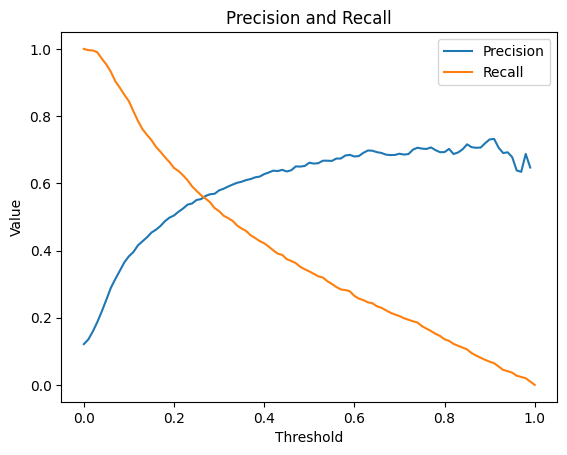

In [26]:
thresholds = np.linspace(0, 1, 101)
precison_list = []
recall_list = []
F1_list = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    precison_list.append(precision)
    recall_list.append(recall)
    F1_list.append(2 * precision * recall / (precision + recall))
from matplotlib import pyplot as plt
plt.plot(thresholds, precison_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('Precision and Recall')
plt.show()    

In [25]:
## Precision and Recall are inversely proportional to each other, they intersect in t = 0.265

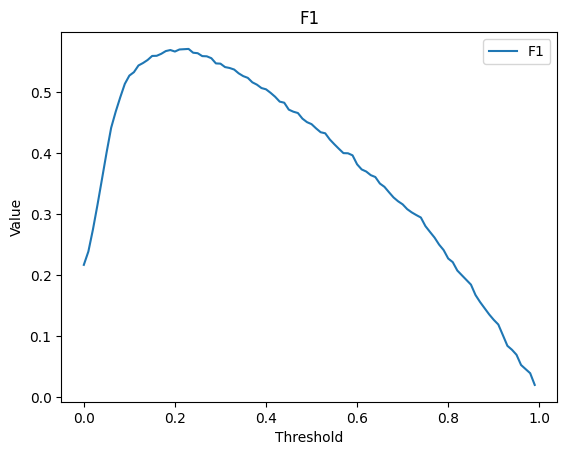

In [28]:
plt.plot(thresholds, F1_list, label='F1')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('F1')
plt.show()

In [29]:
## F1 max at 0.22

In [30]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    y_train = (df_train.y == 'yes').astype(int).values
    y_val = (df_val.y == 'yes').astype(int).values
    del df_train['y']
    del df_val['y']
    X_train = dv.fit_transform(df_train.to_dict(orient='records'))
    X_val = dv.transform(df_val.to_dict(orient='records'))
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    print("%.3f" % roc_auc_score(y_val, y_pred))

0.899
0.899
0.911
0.908
0.912


In [31]:
np.std([0.899,
0.899,
0.911,
0.908,
0.912])

np.float64(0.005706137047074847)

In [32]:
# 0.006

In [36]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
for C in [0.000001, 0.001, 1]:
    auc_list = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        y_train = (df_train.y == 'yes').astype(int).values
        y_val = (df_val.y == 'yes').astype(int).values
        del df_train['y']
        del df_val['y']
        X_train = dv.fit_transform(df_train.to_dict(orient='records'))
        X_val = dv.transform(df_val.to_dict(orient='records'))
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc_list.append(roc_auc_score(y_val, y_pred))
    print("%.3f +- %.3f" % (np.mean(auc_list),np.std(auc_list))) 

0.705 +- 0.012
0.865 +- 0.010
0.906 +- 0.008


In [ ]:
## C = 1 best